# **Systèmes de Recherche d'Images par le Contenu - Approche Deep"**

La recherche d'images basée sur le contenu consiste à retrouver dans une base de données les images visuellement similaires à une image donnée, en se basant sur leurs caractéristiques visuelles.
Avec l’essor de l’apprentissage profond, les méthodes CBIR ont considérablement évolué. Les réseaux neuronaux permettent désormais d’extraire des descripteurs riches et discriminants, capturant à la fois des détails locaux et des informations sémantiques globales.

Dans ce projet, nous allons comparer deux approches principales pour l’extraction de features en CBIR :

1. **Réseau CNN pré-entraîné** (VGG16, ResNet50, etc) :  
   - Utilisé comme extracteur de caractéristiques.  
   - Les couches profondes fournissent des représentations hiérarchiques des images (bords, textures) à des concepts plus complexes.  

2. **Autoencodeur profond** :  
   - Apprend à encoder une image dans un code latent compact puis à la reconstruire.  
   - Le code latent est utilisé comme vecteur de descripteur
  
  **Objectifs du TP :**  

- Charger et prétraiter la base d’images fournie
- Utiliser un CNN pré-entraîné pour extraire des descripteurs  
- Construire et entraîner un autoencodeur profond
- Définir une métrique de similarité (cosine ou euclidienne)  
- Effectuer des recherches CBIR et afficher les images les plus similaires à une image requête  
- Visualiser les feature maps pour comprendre les représentations apprises par chaque type de réseau  



# **2. Importer les librairies nécessaires**

In [ ]:
import numpy as np
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

import torchvision.models as models

# **3. Chargement et prétraitement des images**

La base Corel contient 100 images divisées en 10 classes. La base est déjà divisée en train et test. Les images doivent être prétraitées selon le modèle utilisé.

Afficher quelques images aléatoires pour vérifier que le chargement est correct.

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize images
    transforms.ToTensor(),            # Convert to tensor [0, 1]
    transforms.Normalize(             # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
train_dataset = datasets.ImageFolder(r"C:\Users\LOQ\code\image-indexing-and-watermarking\DeepCIBR\DeepCBIR_Dataset\training_set", transform=transform)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].


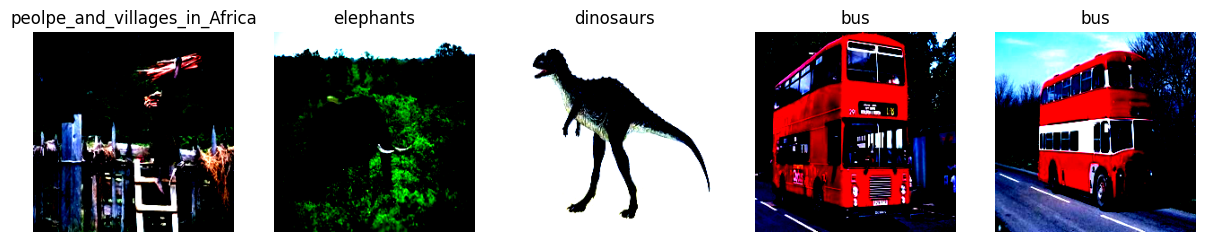

In [11]:
def show_random_images(dataset, class_names=None, num_images=5):
    plt.figure(figsize=(15,3))
    for i in range(num_images):
        idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Change shape for plt.imshow
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if class_names:
            plt.title(class_names[label])
        else:
            plt.title(f"Label: {label}")
    plt.show()
    
show_random_images(train_dataset, class_names=train_dataset.classes, num_images=5)

# **4. CNN Pré-entraîné sur la base ImageNet**
# Construction du Feature Extractor

Utiliser un CNN pré-entraîné comme extracteur de features, charger le modèle (VGG16, ResNet50..) avec `weights='imagenet'`, retirer la couche de classification (include_top=False). Le modèle doit être non entraînable(`trainable=False`)

# Extraction des descripteurs CNN
Générer pour chaque image un vecteur de caractéristiques

# Visualisation des Feature Maps
Comparer feature maps de différentes couches pour comprendre la hiérarchie des
représentations.

In [ ]:
feature_extractor = models.vgg16(weights='IMAGENET1K_V1')

# remove fully connected layers
feature_extractor.classifier = torch.nn.Identity()

feature_extractor.eval()  # Set to evaluation mode

for param in feature_extractor.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\LOQ/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [04:31<00:00, 2.04MB/s] 


In [16]:
def extract_features(model, images):
    with torch.no_grad():                      # Turn off gradient computation (faster, less memory)
        features = model(images)               # Run images through the model
    return features

# Example extraction for one batch
for batch_imgs, batch_labels in train_dataloader:
    batch_features = extract_features(feature_extractor, batch_imgs)
    print(batch_features.shape)                # Shape: [batch, features]
    break                                     # Only one batch for demonstration


torch.Size([32, 1000])


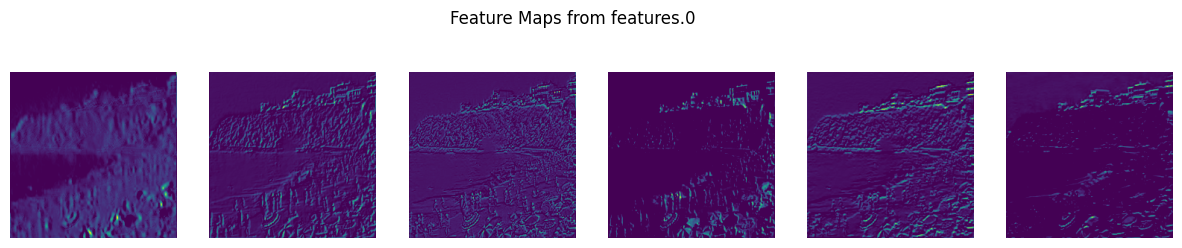

In [ ]:
def show_feature_maps(model, img_tensor, layer_name='features.0', num_maps=6):
    # Get the layer output using forward hooks
    activation = {}
    def hook_fn(module, input, output):
        activation['maps'] = output.detach()
    layer = dict([*model.named_modules()])[layer_name]
    handle = layer.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor.unsqueeze(0))         # Add batch dimension
    handle.remove()
    maps = activation['maps'][0]               # Remove batch dimension
    plt.figure(figsize=(15, 3))
    for i in range(num_maps):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(maps[i].cpu(), cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Feature Maps from {layer_name}')
    plt.show()

# Example visualization for a single image
sample_img, _ = train_dataset[0]
show_feature_maps(feature_extractor, sample_img, layer_name='features.0', num_maps=6)


In [ ]:
feature_extractor_resnet = models.resnet50(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\LOQ/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


 26%|██▋       | 25.9M/97.8M [00:58<02:44, 458kB/s]

# **5. Autoencodeur profond**

# Build Autoencoder
- Encoder : plusieurs couches Conv2D + MaxPooling2D + Flatten + Dense(code_size)

- Decoder : Dense + Reshape + Conv2DTranspose pour reconstruire l'image

- Le modèle final prend une image en entrée et la reconstruit

# Extraction des descripteurs







In [ ]:
descriptors_train = encoder.predict(X_train)
descriptors_test  = encoder.predict(X_test)

# Visualisation du vecteur latent de l’autoencodeur
- Comprendre ce que l'encodeur a appris pour représenter l'image

- Afficher le vecteur code latent produit par l'encodeur

- Comparer avec l'image reconstruite par le decoder

In [ ]:
code = encoder.predict(img[None])[0]
reconstruction= decoder.predict(code[None])[0]

# **Recherche d’images similaires**

 - Comprendre comment utiliser les vecteurs descripteurs  pour rechercher des images proches dans une base.

- Comparer les performances de l’autoencodeur et du CNN pré-entraîné. Choisir la fonction distance ou similarité (cosine, distance euclidienne)

- Visualiser les résultats pour une image requête.